In [24]:
import os
import subprocess
from time import time

class gene:
    def __init__(self, name, primers):
        self.name = name
        self.primers = primers
        return
    
class primer_pair:
    def __init__(self, A, B, name, count):
        self.id = f"{name}-{count}"
        self.gene = name
        self.fseq = A.split("+")[0]
        self.rseq = A.split("+")[3]
        self.fstart = A.split("+")[2]
        self.penalty = B.split("-")[0]
        self.ftm = B.split("-")[1]
        self.rtm = B.split("-")[2]
        self.ampliconlen = B.split("-")[3]
        self.path = []
        self.neighbours = []
        return
            

#specify the location of the output of the primer generator script
os.chdir("/home/flan3@ad.wisc.edu/MplexPrimerPicker/projects/zymofecal/")

In [22]:
#load the primer lists
import pickle
with open("Primers.pickle", "rb") as infile:
    genelist = pickle.load(infile)

#format the gene list to fix primer names
glist = []
count = 0
for g in genelist:
    plist = []
    for p in genelist[g]:
        plist.append(p)
        #print(p.id)
        count+= 1
    glist.append(gene(p.gene.split("|")[-2:], plist))
    print(p.gene)
genelist = glist
print(count, "total primers")

#truncate primers from 3' end to 60bp because ntthal the thermodynamics calculator cannot take >60bp long oligos.
for g in genelist:
    for p in g.primers:
        if len(p.fseq) > 60: #ntthal can't take longer than 60bp long
            p.fseq = p.fseq[len(p.fseq)-60:] #so we truncate from 5'            
        if len(p.rseq) > 60: #ntthal can't take longer than 60bp long

            p.rseq = p.rseq[len(p.rseq)-60:] #so we truncate from 5'

rep_cluster_1320
rep_cluster_663
Inc18
rep_cluster_1351
rep_cluster_1868
rep_cluster_1702
rep_cluster_414
rep_cluster_1817
Col156
rep_cluster_1778
P5/P7
16S
1002 total primers


In [30]:
#function to run ntthal to check primer dimer deltaGs
def run_ntthal(s1, s2):
    try:
        stream = os.popen(f"{ntthal} -s1 {s1} -s2 {s2} -a END1")
        l = stream.readlines()[0].split()
        score1 = float(l[13])
    except:
        print(stream.readlines())
        score1 = 999
    
    try:
        stream = os.popen(f"{ntthal} -s1 {s1} -s2 {s2} -a END2")
        l = stream.readlines()[0].split()
        score2 = float(l[13])
    except:
        print(stream.readlines())
        score2 = 999    
        
    return min(score1, score2)

#function to check the dimer deltaGs between ith gene in the list against other genes in the list (that's 4 primers cross checked)
#stores the results in an adjacency dictionary of (primer1,primer2):mindeltaG
def check_genes(gene, i):
    adjdict = {} #create a local dict to store these things
    for p in gene.primers: #loop through each primer under gene i
        seqs = [0,0,0,0]
        ID = p.id
        seqs[0] = p.fseq
        seqs[1] = p.rseq
        homoGs = []

        #first check self-dimerization once so we don't keep repeating it
        for s in seqs[0:2]:
            homoGs.append(run_ntthal(s, s))
            
        for j in range(i+1, len(genelist)): #for each other gene
            for q in genelist[j].primers: #loop through primers under other genes
                #ts = process_time()
                ID2 = q.id
                seqs[2] = q.fseq
                seqs[3] = q.rseq          
                deltaGs = list(homoGs)

                #do all-way comparisons (completely check for dimers self and hetero)
                #check homodimerization for the other 2 sequences
                for s in seqs[2:4]:
                    deltaGs.append(run_ntthal(s, s))
                #now check for cross-dimerization
                for z in range(4):
                    for y in range(4):
                        if z != y: #skip the homo check steps
                            deltaGs.append(run_ntthal(seqs[y], seqs[z])) #check all heterocombinations, AB != BA when doing End comparisons
                
                #add to the adjacency dictionary
                adjdict[frozenset((ID,ID2))] = min(deltaGs) #add the worst deltaGs
                #print(process_time()-ts) - timing one primer-v-primer comparison - takes 0.015s
    return adjdict



In [ ]:
#parallelized calculation of thermodynamic binding energies for primer pairs
import multiprocessing
from joblib import Parallel, delayed

num_cores = multiprocessing.cpu_count()


#command to run ntthal
ntthal = "~/primer3/src/ntthal -a END1 -mv 200 -dv 3 -n 0.2 -t 25 -d 50" #calculate at 25C, 200mM Naccl, -3mM Mgcl, -0.2mM dNTP, -60oC temp, - 50nM primers

adjdict = {} #adjdict in this format {set(node1.id, node2.id): (deltaG, Tm)}

t1 = time()

adjdictlist = Parallel(n_jobs=15)(delayed(check_genes)(genelist[i], i) for i in range(len(genelist))) #do the parallelized adjmatrix calculations

#ok merge all the separate adjdicts in the adjdictlist into adjdict
adjdict = {}
for d in adjdictlist:
    adjdict.update(d)
    
#store results on harddrive as a pickle
import pickle
with open("adjdict-comm6-endtoend-noadaptors.pickle", "wb") as outfile:
    pickle.dump(adjdict, outfile)

t2 = time()
    
print(f"this took {t2 - t1} seconds")


(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.5300e+02,
        0.0000e+00, 4.0500e+02, 0.0000e+00, 7.2000e+01, 0.0000e+00,
        3.6000e+01, 7.9000e+01, 2.6100e+02, 2.3900e+02, 2.2100e+02,
        2.1810e+03, 2.3080e+03, 5.5650e+03, 1.0050e+03, 2.5750e+03,
        2.4690e+03, 2.1800e+03, 1.4000e+03, 2.9580e+03, 1.5647e+04,
        2.1854e+04, 2.0027e+04, 8.8690e+03, 7.8360e+03, 1.5246e+04,
        1.7216e+04, 1.8747e+04, 3.3798e+04, 3.8865e+04, 4.0630e+04,
        2.7044e+04, 5.7203e+04, 2.9920e+04, 2.2257e+04, 1.9759e+04,
        1.5353e+04, 7.5010e+03, 5.7090e+03, 2.9280e+03, 9.7500e+02,
        3.2200e+02, 1.6800e+02, 1.4000e+01, 2.0000e+00, 3.0000e+00]),
 array([-16882.6    , -16554.13658, -16225.67316, -15897.20974,
        -15568.74632, -15240.2829 , -14911.81948, -14583.35606,
        -14254.89264, -13926.42922, -13597.9658 , -13269.50238,
        -12941.03896, -12612.57554, -12284.11212, -11955.6487 ,
        -11627.18528, -11298.72186, -10970.25844, -10641.79502

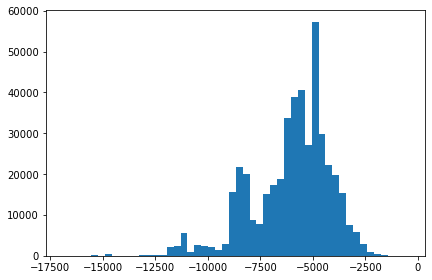

In [33]:
#visualize the distirbution of deltaGs

import matplotlib.pyplot as plot

#check the distributions of deltaGs and Tms
dGs =[]

for v in adjdict.values():
    dGs.append(v)

fig, axs = plot.subplots()
fig.tight_layout()

axs.hist(dGs, bins = 50)
